In [ ]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report

In [ ]:
from google.colab import files
files.upload()

In [ ]:
salaries = pd.read_csv("./clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')
salaries.shape

(8137, 298)

In [ ]:
salaries.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, OEEReilly...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


#Data Cleaning

In [ ]:
def CleanData(df):
    # Drop the first row (question details)
    df.drop(df.index[0], inplace=True)

    df = df.drop(columns='Duration (in seconds)')
    df = df.drop(columns='Q5')
    df = df.drop(columns='Q29')
    df = df.drop(columns='Q29_buckets')

    return df

salaries = CleanData(salaries)
salaries.shape

(8136, 294)

###**Impute missing values (single column responses)**

1. Identify columns with single column responses

2. Address missing values in those columns

In [ ]:
def ImputingSingleColMissingValues(df):

    single_col_names = [col for col in df.columns if '_' not in col] #extract single column names and store them as a list
    single_col_names.append('Q29_Encoded') #including Q29_Encoded

    null_perc_1 = df[single_col_names].isnull().sum()*100/len(df) #checking the percentage of null values
    print("Percentage of null values: ")
    print(null_perc_1)

    #address missing values in single column responses in df
    for question, percentage in null_perc_1.items():
      if percentage > 40:
        df = df.drop(columns=[question]) #dropping any column with more than 40% null values
        single_col_names.remove(question)

    df['Q9'].fillna(0, inplace=True) #filling empty values of question 9 as 0

    mode_q16 = df['Q16'].mode()[0]
    df['Q16'].fillna(mode_q16, inplace=True) #filling empty values of question 16 with the mode

    mode_q30 = df['Q30'].mode()[0]
    df['Q30'].fillna(mode_q30, inplace=True) #filling empty values of question 30 with the mode


    print("Percentage of null values (make sure they are all zeros): ")
    print(df[single_col_names].isnull().sum()*100/len(df))
    assert df[single_col_names].isnull().values.sum() == 0, \
        "There are still missing values remaining!"

    return df, single_col_names

salaries, columns_without_underscore = ImputingSingleColMissingValues(salaries)

Percentage of null values: 
Q2              0.000000
Q3              0.000000
Q4              0.000000
Q8              0.000000
Q9             36.147984
Q11             0.000000
Q16             8.407080
Q22            80.162242
Q23             0.000000
Q24             0.000000
Q25             0.000000
Q26             0.000000
Q27             0.000000
Q30             0.614553
Q32            77.126352
Q43            45.759587
Q29_Encoded     0.000000
dtype: float64
Percentage of null values (make sure they are all zeros): 
Q2             0.0
Q3             0.0
Q4             0.0
Q8             0.0
Q9             0.0
Q11            0.0
Q16            0.0
Q23            0.0
Q24            0.0
Q25            0.0
Q26            0.0
Q27            0.0
Q30            0.0
Q29_Encoded    0.0
dtype: float64


###**Encode categorical features (sinlge column responses)**

In [ ]:
for i in columns_without_underscore:
  print(i, '   ', salaries[i].unique())

Q2     ['55-59' '30-34' '70+' '40-44' '50-54' '25-29' '60-69' '35-39' '22-24'
 '45-49' '18-21']
Q3     ['Man' 'Woman' 'Prefer not to say' 'Prefer to self-describe' 'Nonbinary']
Q4     ['France' 'Germany' 'Australia' 'United States of America' 'Singapore'
 'Italy' 'Taiwan' 'Brazil' 'Argentina' 'Chile' 'Other' 'Japan' 'Canada'
 'Indonesia' 'India' 'Colombia' 'Pakistan' 'Mexico' 'Turkey' 'Spain'
 'Cameroon' 'Nigeria'
 'United Kingdom of Great Britain and Northern Ireland' 'Ethiopia'
 'Tunisia' 'Philippines' 'Egypt' 'South Korea' 'Peru' 'Thailand'
 'Iran, Islamic Republic of...' 'Netherlands' 'Ghana' 'Portugal' 'Russia'
 'Viet Nam' 'Poland' 'Saudi Arabia' 'Bangladesh' 'Czech Republic' 'Israel'
 'China' 'Sri Lanka' 'South Africa' 'Hong Kong (S.A.R.)' 'Kenya' 'Romania'
 'Morocco' 'Ukraine' 'United Arab Emirates' 'Nepal' 'Belgium' 'Malaysia'
 'Ecuador' 'I do not wish to disclose my location' 'Algeria' 'Zimbabwe'
 'Ireland']
Q8     ['Some college/university study without earning a bachelor\x81

In [ ]:
#Encode categorical features in the single column responses for ordinal values
Q2_mapping = {'18-21': 0, '22-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, '40-44': 5, '45-49': 6, '50-54': 7, '55-59': 8, '60-69': 9, '70+': 10}
salaries['Q2'] = salaries['Q2'].replace(Q2_mapping)

Q8_mapping = {'I prefer not to answer': 0, 'No formal education past high school': 1, 'Some college/university study without earning a bachelor\x81E\x80\x81Es degree': 2, 'Bachelor\x81E\x80\x81Es degree': 3, 'Master\x81E\x80\x81Es degree': 4, 'Doctoral degree': 5, 'Professional doctorate': 6}
salaries['Q8'] = salaries['Q8'].replace(Q8_mapping)

Q9_mapping = {'No': 0, 'Yes': 1}
salaries['Q9'] = salaries['Q9'].replace(Q9_mapping)

Q11_mapping = {'I have never written code': 0, '< 1 years': 1, '1-3 years': 2, '3-5 years': 3, '5-10 years': 4, '10-20 years': 5, '20+ years': 6}
salaries['Q11'] = salaries['Q11'].replace(Q11_mapping)

Q16_mapping = {'I do not use machine learning methods': 0, 'Under 1 year': 1, '1-2 years': 2, '2-3 years': 3, '3-4 years': 4, '4-5 years': 5, '5-10 years': 6, '10-20 years': 7}
salaries['Q16'] = salaries['Q16'].replace(Q16_mapping)

Q25_mapping = {'0-49 employees': 0, '50-249 employees': 1, '250-999 employees': 2, '1000-9,999 employees': 3, '10,000 or more employees': 4}
salaries['Q25'] = salaries['Q25'].replace(Q25_mapping)

Q26_mapping = {'0': 0, '2-Jan': 1, '4-Mar': 2, '9-May': 3, '14-Oct': 4, '15-19': 5, '20+': 6}
salaries['Q26'] = salaries['Q26'].replace(Q26_mapping)

Q27_mapping = {'I do not know': 0, 'No (we do not use ML methods)': 1, 'We are exploring ML methods (and may one day put a model into production)': 2, 'We use ML methods for generating insights (but do not put working models into production)': 3, 'We recently started using ML methods (i.e., models in production for less than 2 years)': 4, 'We have well established ML methods (i.e., models in production for more than 2 years)': 5}
salaries['Q27'] = salaries['Q27'].replace(Q27_mapping)

Q30_mapping = {'$0 ($USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3, '$10,000-$99,999': 4, '$100,000 or more ($USD)': 5}
salaries['Q30'] = salaries['Q30'].replace(Q30_mapping)

In [ ]:
#Separating and encoding the values that cannot be ordinally encoded
Q3_values = salaries['Q3'].unique()
for i in Q3_values:
  salaries[i] = salaries['Q3'].apply(lambda x: 1 if i in x else 0)
salaries.drop(columns=['Q3'], inplace=True)

Q4_values = salaries['Q4'].unique()
for i in Q4_values:
  salaries[i] = salaries['Q4'].apply(lambda x: 1 if i in x else 0)
salaries.drop(columns=['Q4'], inplace=True)

Q23_values = salaries['Q23'].unique()
for i in Q23_values:
  salaries[i] = salaries['Q23'].apply(lambda x: 1 if i in x else 0)
salaries.drop(columns=['Q23'], inplace=True)

Q24_values = salaries['Q24'].unique()
for i in Q24_values:
  salaries[i] = salaries['Q24'].apply(lambda x: 1 if i in x else 0)
salaries.drop(columns=['Q24'], inplace=True)

In [ ]:
salaries.shape

(8136, 377)

###**Handling categorical features (multi column responses)**

In [ ]:
multi_col_names = [col for col in salaries.columns if '_' in col] #Identify multi-column responses
multi_col_names.remove('Q29_Encoded')

for i in multi_col_names:
  salaries[i] = salaries[i].apply(lambda x: 1 if pd.notna(x) and x.strip() != '' else 0) #replacing the null values with 0 and the filled values with 1 (perform encoding for categorical features)

#Address missing values in the multi-column responses

multi_col_names_short = []
for item in multi_col_names:
    value = item.split('_')[0]
    if value not in multi_col_names_short:
        multi_col_names_short.append(value) #storing question numbers in a list to easily link them

for i in multi_col_names_short: #checking the unanswered percentage of each question
  test_df = pd.DataFrame()
  for j in salaries.columns:
    if i in j:
      test_df[j] = salaries[j] #making a test data frame for each question to be checked
  test_df['test'] = test_df.sum(axis=1) #getting the sum value of each row
  null_perc_3 = (test_df['test'] == 0).sum() / test_df['test'].shape[0] * 100 #checking the percentage through the sum value of each row
  if null_perc_3 > 40:
    for j in salaries.columns:
      if i in j:
        salaries = salaries.drop(columns=[j]) #removing any question that has more than 40% unanswered result

In [ ]:
salaries.shape

(8136, 281)

###**Drop the target variable(s) and get the target variable**

In [ ]:
#Make sure there are no missing values remaining in the dataset
assert salaries.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in salaries!".format(
        salaries.isnull().values.sum()
    )

In [ ]:
target = salaries['Q29_Encoded']#get the target variable

#Drop the target variables from the feature set
features = salaries.drop(columns=['Q29_Encoded'])

#Make sure the target variables are not included in the feature set
for col in features.columns:
    assert 'Q29' not in col, \
        "Target variable ({}) is still in the dataset".format(col)

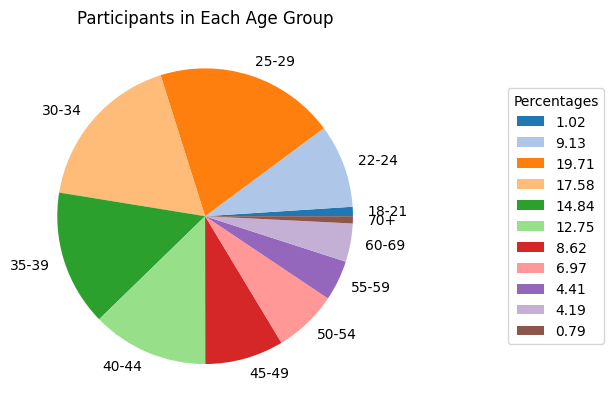

In [ ]:
features_copy = features.copy()
age_mapping = {v: k for k, v in Q2_mapping.items()} #define the mapping dictionary

features_copy['Age_Group'] = features_copy['Q2'].map(age_mapping) #map the numerical values in 'Q2' to the corresponding age ranges

grouped_age = features_copy.groupby('Age_Group').size().reset_index(name='age_count') #group by the 'Age_Group' column instead of 'Q2'

total_count = grouped_age['age_count'].sum()
age_percentages = ((grouped_age['age_count'] / total_count) * 100).round(2)

plt.pie(grouped_age['age_count'], labels=grouped_age['Age_Group'], colors=plt.cm.tab20.colors)

plt.legend(age_percentages, loc="center left", bbox_to_anchor=(1.3, 0.5), title="Percentages", fontsize='medium')

plt.title('Participants in Each Age Group')
plt.show()

#Exploratory Feature Analysis


## **Feature Engineering/Generation (Optional)**

- Create new feature(s) using existing features!

In [ ]:
#Create new features (feature generation)
features['generated'] = (features['Q30'] + features['Q11'] + features['Manager (Program, Project, Operations, Executive-level, etc)'] + features['Academics/Education'])**2

## Split data into training and test sets

In [ ]:
train_df, test_df, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

## **Feature Selection**

- Select the features based on the criteria of your choice

In [ ]:
lasso_model = Lasso(alpha=0.08) #lasso regression model

lasso_model.fit(train_df, y_train) #fitting the model

coefficients = lasso_model.coef_ #storing the coefficients

selected_features = train_df.columns[coefficients != 0] #selecting the features that have a non zero coefficient

In [ ]:
train_df_selected = train_df[selected_features]

## **Visualization**

- Make visualization to better understand your data

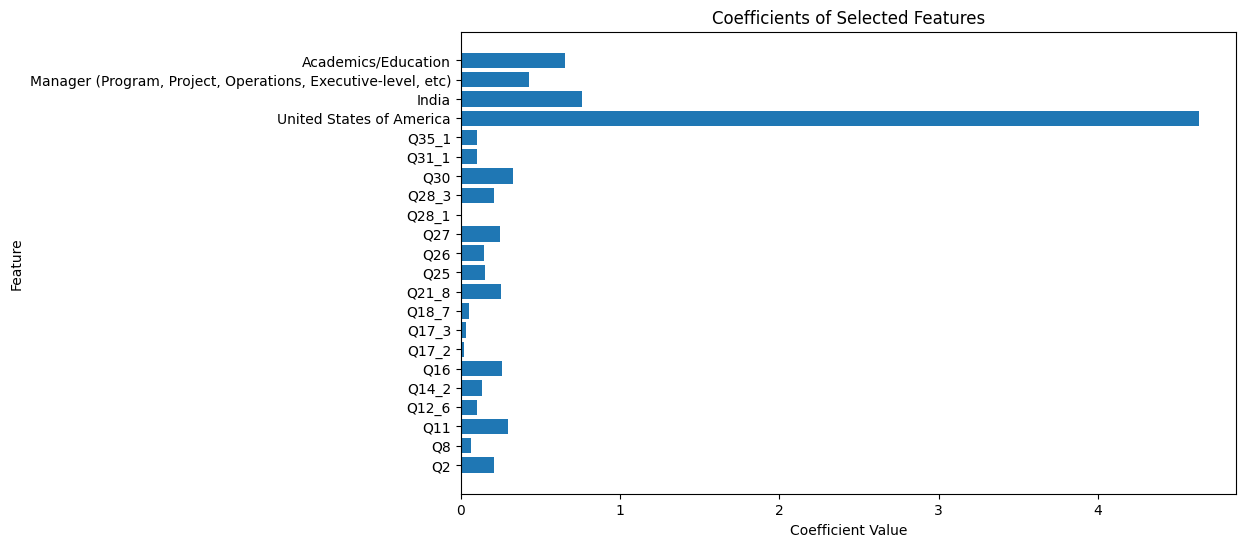

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(selected_features, np.abs(coefficients[coefficients != 0])) #plotting the selected features and their coefficients
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Selected Features')
plt.show()

## **Apply the same feature engineering/selection to test data**

In [ ]:
test_df_selected = test_df[selected_features]

In [ ]:
X_train = train_df_selected.values
X_test = test_df_selected.values
y_train = y_train.values
y_test = y_test.values

#Model Implementation

## Implement Ordinal Logistic Regression Model

In [ ]:
#from chat
class OrdinalLogisticRegression():
    def __init__(self, max_iter=500, regu_parameter=0.1, solver='lbfgs'): #3 hyperparameters used and defined
        self.regu_parameter = regu_parameter #regularisation parameter to be tuned
        self.max_iter = max_iter #type of solver used to be tuned
        self.solver = solver

        self.classes_ = []
        self.models_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        self.models_ = []

        # Train k-1 binary logistic regression models
        for i, c in enumerate(self.classes_[:-1]): # We need only k-1 classifiers
            y_i = np.where(y <= c, 0, 1) # label is 0 if the salary bucket is 0 to c, otherwise label is 1
            model = LogisticRegression(max_iter = self.max_iter, C = self.regu_parameter, solver = self.solver) # Binary logistic regression model
            model.fit(X, y_i)
            self.models_.append(model)

        return self

    def predict_proba(self, X):
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Predicted probabilities for k-1 binary logistic regression models (initialize placeholders)
        binary_probabilities = np.empty((X.shape[0], len(self.models_), 2), dtype=float)

        # Make predictions of k-1 binary logistic regression models
        for i, model in enumerate(self.models_):
            binary_probabilities[:, i] = model.predict_proba(X) # predicted probabilities by the ith binary logistic regression model

        # Compute the probabilities to be in each class
        k = len(self.classes_)
        proba = np.empty((X.shape[0], k), dtype=float) # predicted probabilities for all the data in X (shape=(X.shape[0], k))

        proba[:, 0] = binary_probabilities[:, 0, 0] # 0th probability

        for i in range(1, k-1):
            # ith probability
            # (prob of belonging to class 0 for the ith model - prob of belonging to class 0 for the (i-1)th model
            proba[:, i] = binary_probabilities[:, i, 0] - binary_probabilities[:, i-1, 0]

        proba[:, -1] = binary_probabilities[:, k-2, 1] # (k-1)th probability

        assert (np.round(proba.sum(axis=1), 5) == 1).all(), \
            'There is a problem in the probability computation'
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis = 1)

    def get_feature_importance(self): #a method to get the coefficient values of each feature through all the models
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."
        feature_importance = []

        for model in self.models_:
            feature_importance.append(model.coef_[0])

        return np.array(feature_importance)

    def get_params(self, deep=True):
        return {'max_iter': self.max_iter, 'regu_parameter': self.regu_parameter, 'solver': self.solver}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [ ]:
model_a = OrdinalLogisticRegression() #quick model fit to test the class
model_a.fit(X_train,y_train)
prediction = model_a.predict(X_train)

count = 0
for i,y_1 in enumerate(y_train): #quick accuracy check to test the class
  if y_1 == prediction[i]:
    count+=1
print(count/len(y_train))

0.42347879532882604


## Run k-fold cross validation

- Report the average/variance of accuracies across folds

In [ ]:
accuracies = [] #initialize accuracies

k = 10 #defining number of folds

kf = KFold(n_splits=k, shuffle=True, random_state=42) #initialize k-fold model

for (train_index, test_index) in kf.split(X_train):
  X_train_CV, X_val = X_train[train_index], X_train[test_index] #storing each fold train and validation feature
  y_train_CV, y_val = y_train[train_index], y_train[test_index] #storing each fold train and validation target
  model_b = OrdinalLogisticRegression()
  model_b.fit(X_train_CV,y_train_CV) #fitting each fold train and validation set
  prediction = model_b.predict(X_val)
  count = 0
  for i,y_1 in enumerate(y_val): #calculating the accuracies and storing them for each fold
    if y_1 == prediction[i]:
      count+=1
  accuracies.append(count/len(y_val))

print("Average accuracy    : ", np.mean(accuracies))
print("Variance of accuracy: ", np.var(accuracies))

Average accuracy    :  0.4144083658277206
Variance of accuracy:  0.0003626101364505271


## Bias-variance trade-off

[bias_variance_decomp.py](https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py)

Below is a function you can use to compute the bias and variance of your ordinal logistic regression model. Using this function, analyze the ordinal logistic regression model performance based on bias-variance trade-off.

In [ ]:
def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]

def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    num_rounds=10,
    random_seed=0
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.

    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.

    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.

    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.

    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.

    num_rounds : int (default=10)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.

    random_seed : int (default=0)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.

    Returns
    ----------
    avg_bias, avg_var : returns the average bias, and average bias (all floats),
                        where the average is computed over the data points
                        in the test set.

    """
    loss = "mse"

    for ary in (X_train, y_train, X_test, y_test):
        assert type(ary) == np.ndarray, \
            "X_train, y_train, X_test, y_test have to be NumPy array. \
            If e.g., X_train is a pandas DataFrame, convert it to NumPy array \
            via X_train=X_train.values."

    rng = np.random.RandomState(random_seed)

    # All the predictions across different rounds
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.float64)

    for i in range(num_rounds):
        # Randomly sample training data
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Fit the model using the randomly sampled data
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Mean prediction across runs using different dataset for each data point
    main_predictions = np.mean(all_pred, axis=0)

    # Average bias across different rounds
    avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size

    # Average variance across different rounds
    avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_bias, avg_var

In [ ]:
# Usage example
model_both = OrdinalLogisticRegression()
avg_bias_both, avg_var_both = bias_variance_decomp(model_both, X_train, y_train, X_train, y_train, num_rounds=10, random_seed=0) #fitting X_train for both training and testing and getting the bias variance

print(avg_bias_both, avg_var_both)

X_train_hold, X_val_hold, y_train_hold, y_val_hold = train_test_split(X_train, y_train, test_size=0.2, random_state=0) #getting avalidation split

model_hold = OrdinalLogisticRegression()
avg_bias_hold, avg_var_hold = bias_variance_decomp(model_hold, X_train_hold, y_train_hold, X_val_hold, y_val_hold, num_rounds=10, random_seed=0) #fitting X_train for training and X_val for testing, then getting the bias variance

print(avg_bias_hold, avg_var_hold)

12.253896742470806 0.8277258758451137
12.406551459293395 0.9801612903225807


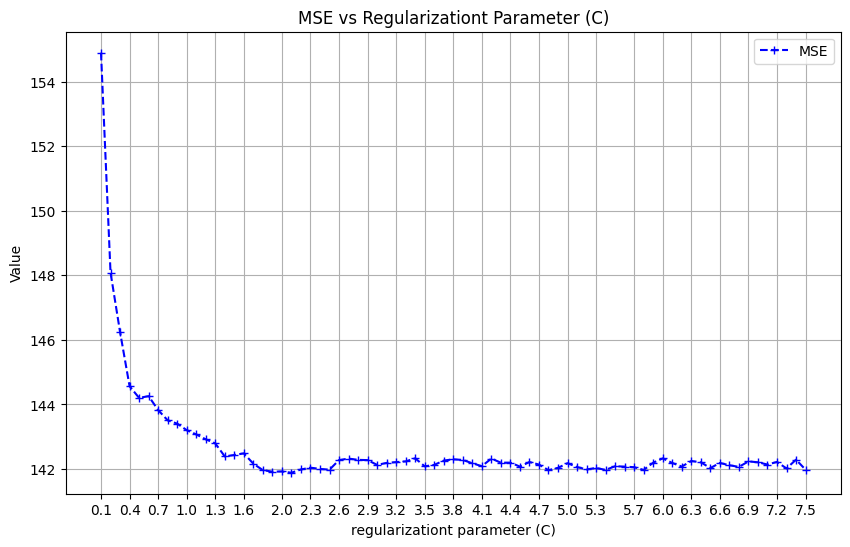

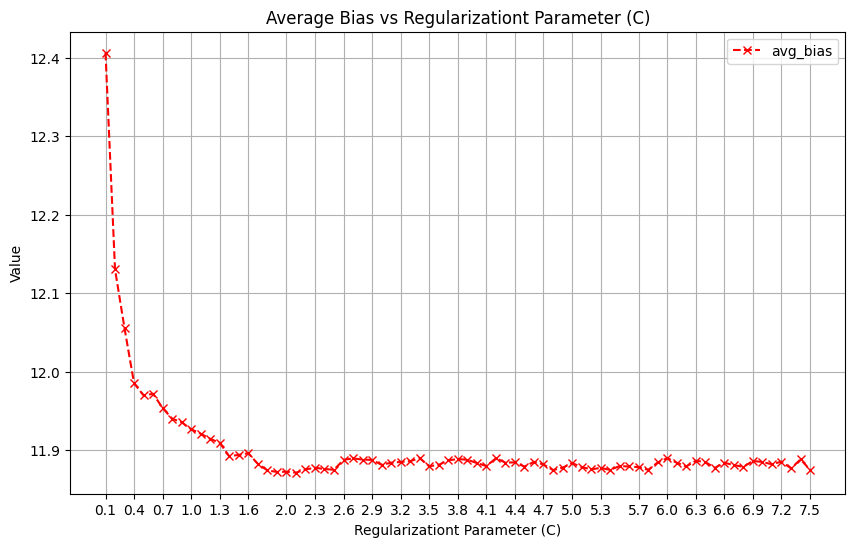

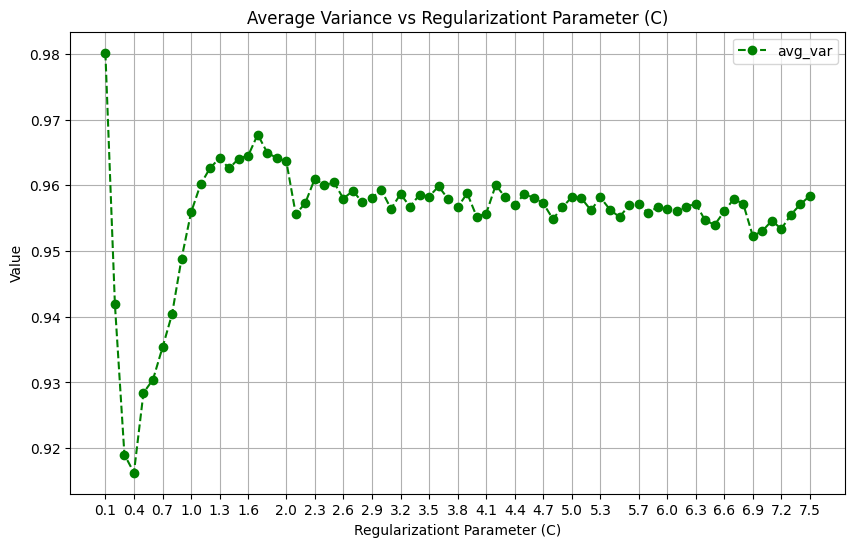

In [ ]:
regu_parameter_values = [i/10 for i in range(1, 76)] #defining the values to go through the regularizationg parameter from 0.1 to 7.5
avg_bias_list = [] #initialize avg_bias_list
avg_variance_list = [] #initialize avg_variance_list
MSE_list = [] #initialize MSE_list
X_ticks = [round(x, 1) for x in list(0.1 + (7.4 / 24 * i) for i in range(25))]

for rp in regu_parameter_values:
  model_bias_vs_variance = OrdinalLogisticRegression(500, rp, 'lbfgs')
  avg_bias, avg_var = bias_variance_decomp(model_bias_vs_variance, X_train_hold, y_train_hold, X_val_hold, y_val_hold, num_rounds=10, random_seed=0) #fitting X_train for training and X_val for testing, then getting the bias variance
  avg_bias_list.append(avg_bias)
  avg_variance_list.append(avg_var)
  MSE_list.append((avg_bias**2)+avg_var)

plt.figure(figsize=(10, 6))
plt.plot(regu_parameter_values, MSE_list, marker='+', linestyle='--', color='b', label='MSE')
plt.title('MSE vs Regularizationt Parameter (C)')
plt.xlabel('regularizationt parameter (C)')
plt.ylabel('Value')
plt.xticks(X_ticks)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(regu_parameter_values, avg_bias_list, marker='x', linestyle='--', color='r', label='avg_bias')
plt.title('Average Bias vs Regularizationt Parameter (C)')
plt.xlabel('Regularizationt Parameter (C)')
plt.ylabel('Value')
plt.xticks(X_ticks)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(regu_parameter_values, avg_variance_list, marker='o', linestyle='--', color='g', label='avg_var')
plt.title('Average Variance vs Regularizationt Parameter (C)')
plt.xlabel('Regularizationt Parameter (C)')
plt.ylabel('Value')
plt.xticks(X_ticks)
plt.grid(True)
plt.legend()
plt.show()

#Model Tuning

## Grid Search

- Grid search will take time to complete - but if it does not finish in a few hours, you're probably trying too many combinations
- A recommended approach is to try a small number of combinations with a wide range first (for continuous value hyperparameters)! Then gradually increase the points that seem to be near optimal

In [ ]:
regu_parameter_values = [i/10 for i in range(1, 76)] #defining the values to go through the regularizationg parameter from 0.1 to 7.5
solver_values = ['liblinear', 'lbfgs', 'sag', 'saga'] #defining the types of solvers to check

#defining the hyperparameter grid
param_grid = {
    'regu_parameter': regu_parameter_values, #specify the values to search for hyperparameter
    'solver': solver_values #specify the values to search for the solver
}

model_c = OrdinalLogisticRegression() #defining the model

grid_search = GridSearchCV(estimator=model_c, param_grid=param_grid, scoring='f1_weighted', cv=5) #perform grid search
grid_search.fit(X_train, y_train)

#getting the best hyperparameters
best_regu_parameter = grid_search.best_params_['regu_parameter']
best_solver = grid_search.best_params_['solver']
print('best_regu_parameter', best_regu_parameter)
print('best_solver', best_solver)

best_regu_parameter 6.9
best_solver sag


## Visualize the feature importance of your model

In [ ]:
#fitting the model with the best hyperparameters and X_train
model_d = OrdinalLogisticRegression(500, best_regu_parameter, best_solver)
model_d.fit(X_train, y_train)
prediction_train = model_d.predict(X_train)

report_d = classification_report(y_train, prediction_train) #getting weighted f1 scores
print('with  best hyperparameters', report_d)

#fitting the model with the best hyperparameters and X_train
model_e = OrdinalLogisticRegression()
model_e.fit(X_train, y_train)
prediction_train_without = model_e.predict(X_train)

report_e = classification_report(y_train, prediction_train_without) #getting weighted f1 scores
print('without  best hyperparameters', report_e)

with  best hyperparameters               precision    recall  f1-score   support

         0.0       0.51      0.96      0.66      2472
         1.0       0.25      0.02      0.03       617
         2.0       0.23      0.02      0.03       487
         3.0       0.20      0.04      0.07       370
         4.0       0.13      0.06      0.08       326
         5.0       0.17      0.05      0.08       297
         6.0       0.12      0.02      0.03       255
         7.0       0.15      0.05      0.08       234
         8.0       0.08      0.01      0.01       168
         9.0       0.22      0.01      0.02       158
        10.0       0.19      0.33      0.24       315
        11.0       0.25      0.22      0.23       226
        12.0       0.32      0.52      0.39       284
        13.0       0.25      0.08      0.12       174
        14.0       0.33      0.09      0.14       125

    accuracy                           0.43      6508
   macro avg       0.23      0.16      0.15      6508

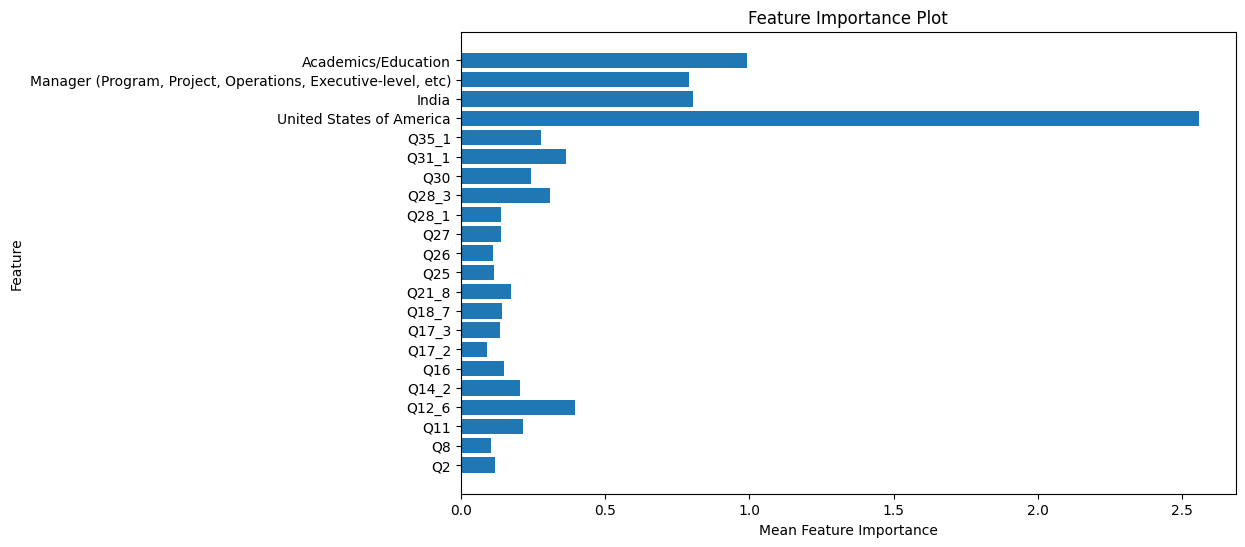

In [ ]:
#Visualize feature importance of the ordinal logistic regression model

feature_importance = np.abs(model_d.get_feature_importance()) #getting the coefficient of each feature for each model

mean_feature_importance = feature_importance.mean(axis=0) #getting the average value of each feature

plt.figure(figsize=(10, 6))
plt.barh(selected_features, mean_feature_importance)
plt.xlabel('Mean Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

#Testing

In [ ]:
#Using the best-performing model, evaluate the model performance both on the training set and test set

model_f = OrdinalLogisticRegression(500, best_regu_parameter, best_solver)
model_f.fit(X_train,y_train)
prediction_test = model_f.predict(X_test)

report_f = classification_report(y_test, prediction_test) #getting weighted f1 scores

print(report_f)

              precision    recall  f1-score   support

         0.0       0.48      0.93      0.63       586
         1.0       0.24      0.02      0.04       175
         2.0       0.17      0.02      0.04       127
         3.0       0.12      0.02      0.04        94
         4.0       0.13      0.06      0.09        95
         5.0       0.21      0.10      0.14        69
         6.0       0.00      0.00      0.00        63
         7.0       0.05      0.02      0.03        55
         8.0       0.00      0.00      0.00        54
         9.0       0.00      0.00      0.00        39
        10.0       0.19      0.29      0.23        89
        11.0       0.20      0.26      0.22        43
        12.0       0.27      0.50      0.35        58
        13.0       0.56      0.15      0.24        59
        14.0       0.00      0.00      0.00        22

    accuracy                           0.39      1628
   macro avg       0.17      0.16      0.14      1628
weighted avg       0.28   

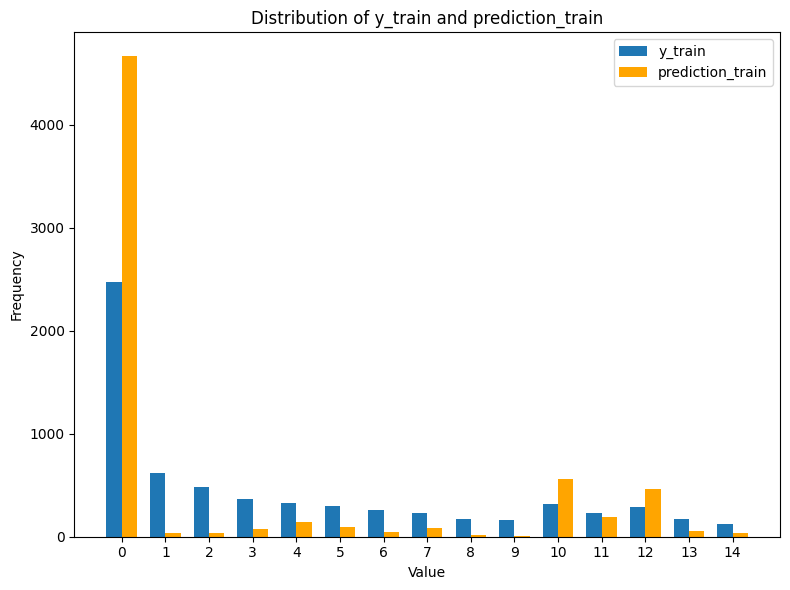

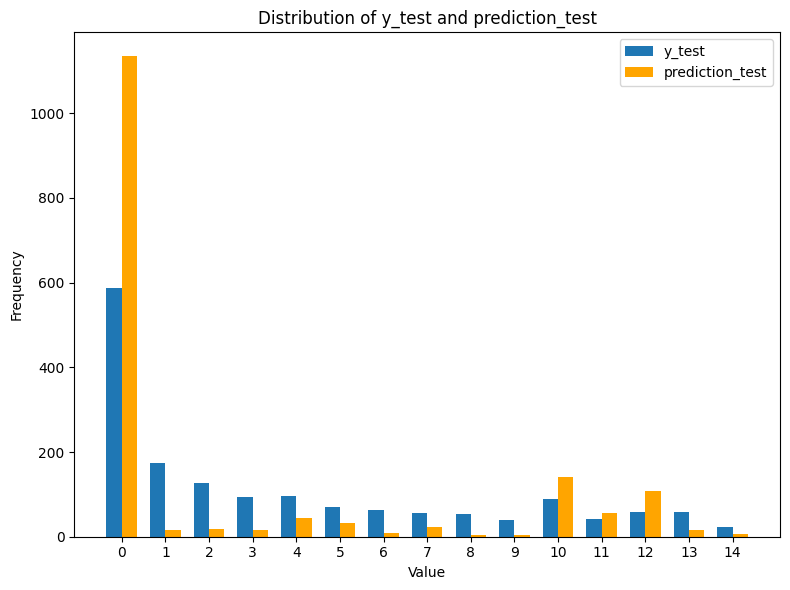

In [ ]:
#Plot the distribution of true target variable values and their predictions on both the training set and test set
index = np.arange(max(max(y_train), max(prediction_train)) + 1)
#Set the width of the bars
bar_width = 0.35
y_train = np.array(y_train, dtype=np.int64)
prediction_train = np.array(prediction_train, dtype=np.int64)
#Plotting
plt.figure(figsize=(8, 6))
bar1 = plt.bar(index, np.bincount(y_train), bar_width, label='y_train')
bar2 = plt.bar(index + bar_width, np.bincount(prediction_train), bar_width, label='prediction_train', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of y_train and prediction_train')
plt.xticks(index + bar_width / 2, range(max(max(y_train), max(prediction_train)) + 1))
plt.legend()
plt.tight_layout()
plt.show()

#Set the x locations for the groups
index = np.arange(max(max(y_test), max(prediction_test)) + 1)
#Set the width of the bars
bar_width = 0.35
y_test = np.array(y_test, dtype=np.int64)
prediction_test = np.array(prediction_test, dtype=np.int64)
#Plotting
plt.figure(figsize=(8, 6))
bar1 = plt.bar(index, np.bincount(y_test), bar_width, label='y_test')
bar2 = plt.bar(index + bar_width, np.bincount(prediction_test), bar_width, label='prediction_test', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of y_test and prediction_test')
plt.xticks(index + bar_width / 2, range(max(max(y_test), max(prediction_test)) + 1))
plt.legend()
plt.tight_layout()
plt.show()